In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="6"

Sun Jan 21 23:01:37 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   44C    P0    47W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.rand_prior import Prior
from model.latent.lse_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.n_prior_embeddings = 10
hp.M = 1000
hp.N = 32
hp.const_sigma = False

In [5]:
# ''' Find Optimum Log-Sigma'''
# from util.loglikelihood import get_optimum_log_sigma
# from util.circle import generate_circle_data_torch

# p_samples1 = generate_circle_data_torch(hp.M).cuda()
# p_samples2 = generate_circle_data_torch(hp.M).cuda()
# log_sigmas = np.array([get_optimum_log_sigma(p_samples1, p_samples2) for _ in range(100)])
# optimum_log_sigma = np.median(log_sigmas)
# print(optimum_log_sigma)

hp.init_log_sigma = -3

In [6]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 7.62939453125e-05
latent 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [7]:
save_dir = '/data/scpark/save/lse/train01.21-1/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 383684
-rw-rw-r-- 1 scpark scpark   263972  1월 21 23:01 events.out.tfevents.1705845628.GPUSVR11
-rw-rw-r-- 1 scpark scpark 37976238  1월 21 23:00 save_0
-rw-rw-r-- 1 scpark scpark   562724  1월 21 23:00 events.out.tfevents.1705845480.GPUSVR11
-rw-rw-r-- 1 scpark scpark  9144222  1월 21 22:57 events.out.tfevents.1705843319.GPUSVR11
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:56 save_90000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:52 save_80000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:49 save_70000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:45 save_60000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:40 save_50000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:36 save_40000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:33 save_30000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:29 save_20000
-rw-rw-r-- 1 scpark scpark 37980897  1월 21 22:25 save_10000
-rw-rw-r-- 1 scpark scpark       40  1월 21 22:21 events.out.tfevents.1705843283.GPUSVR11
-rw-rw-r-- 1 scpark scpark  1045700

### Dataset

In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [9]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [10]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


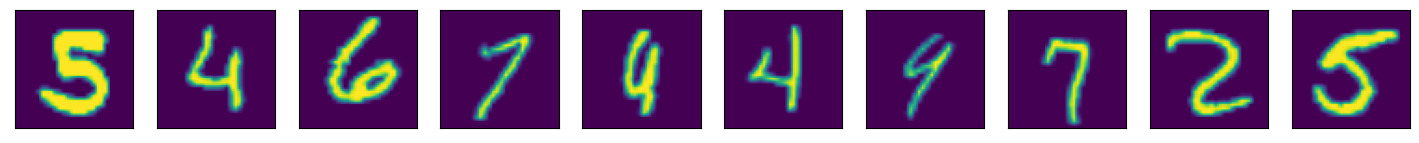

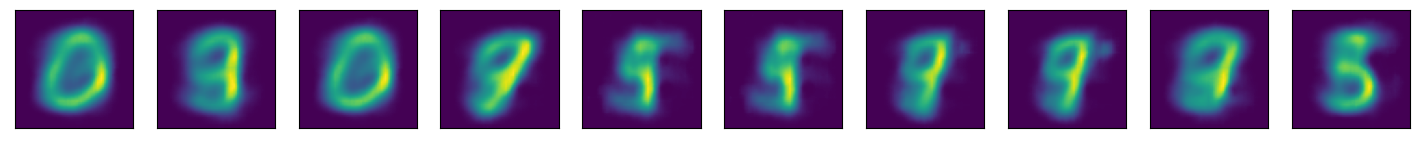

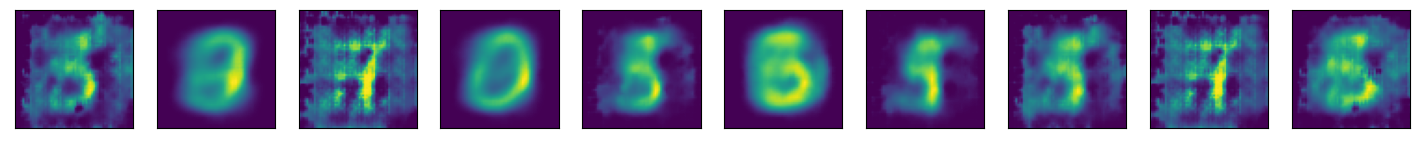

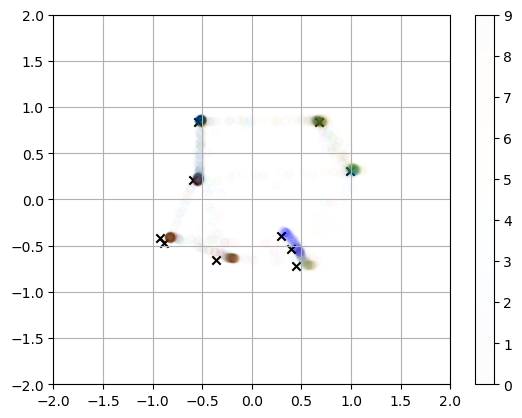

39001
lse_loss -3.0809736251831055
recon_loss 0.1805119812488556
39002
lse_loss -3.0431437492370605
recon_loss 0.17737704515457153
39003
lse_loss -3.3654074668884277
recon_loss 0.18770065903663635
39004
lse_loss -3.628383159637451
recon_loss 0.1988532543182373
39005
lse_loss 0.906367301940918
recon_loss 0.17333059012889862
39006
lse_loss -2.882145881652832
recon_loss 0.2151384800672531
39007
lse_loss -3.5445785522460938
recon_loss 0.21628323197364807
39008
lse_loss -0.9825282096862793
recon_loss 0.20968137681484222
39009
lse_loss -3.662452220916748
recon_loss 0.2010839432477951
39010
lse_loss -3.1796345710754395
recon_loss 0.18027108907699585
39011
lse_loss -3.774944305419922
recon_loss 0.17524230480194092
39012
lse_loss -3.6793980598449707
recon_loss 0.1900729387998581
39013
lse_loss -3.1118884086608887
recon_loss 0.20986032485961914
39014
lse_loss -3.515939235687256
recon_loss 0.20366913080215454
39015
lse_loss -3.7922563552856445
recon_loss 0.1898915022611618
39016
lse_loss -3.59480

39132
lse_loss -4.07119083404541
recon_loss 0.17523586750030518
39133
lse_loss -4.221141338348389
recon_loss 0.19629549980163574
39134
lse_loss -4.342300891876221
recon_loss 0.1951027512550354
39135
lse_loss -4.183236122131348
recon_loss 0.19034084677696228
39136
lse_loss -4.043959140777588
recon_loss 0.1750527322292328
39137
lse_loss -4.106576919555664
recon_loss 0.1833954155445099
39138
lse_loss -4.0419087409973145
recon_loss 0.17547258734703064
39139
lse_loss -4.202947616577148
recon_loss 0.1850123256444931
39140
lse_loss -4.070240497589111
recon_loss 0.19999316334724426
39141
lse_loss -3.8975629806518555
recon_loss 0.2039208859205246
39142
lse_loss -4.012026786804199
recon_loss 0.19214145839214325
39143
lse_loss -3.9403200149536133
recon_loss 0.1828157901763916
39144
lse_loss -3.3320608139038086
recon_loss 0.184908926486969
39145
lse_loss -3.285950183868408
recon_loss 0.19566085934638977
39146
lse_loss 2.568181037902832
recon_loss 0.18421506881713867
39147
lse_loss -4.1205329895019

lse_loss -2.9871997833251953
recon_loss 0.1765763759613037
39262
lse_loss -4.091970920562744
recon_loss 0.16581392288208008
39263
lse_loss -3.457871437072754
recon_loss 0.18271395564079285
39264
lse_loss -3.8585872650146484
recon_loss 0.20719723403453827
39265
lse_loss -4.181619644165039
recon_loss 0.17239467799663544
39266
lse_loss -4.216490268707275
recon_loss 0.1797175407409668
39267
lse_loss -3.82741641998291
recon_loss 0.1811288297176361
39268
lse_loss -3.9710330963134766
recon_loss 0.17723485827445984
39269
lse_loss -4.07421350479126
recon_loss 0.17527608573436737
39270
lse_loss -3.784061908721924
recon_loss 0.19335100054740906
39271
lse_loss -4.085036277770996
recon_loss 0.18062961101531982
39272
lse_loss -2.178391933441162
recon_loss 0.1965293288230896
39273
lse_loss -4.077373504638672
recon_loss 0.18303915858268738
39274
lse_loss -4.134518146514893
recon_loss 0.18506726622581482
39275
lse_loss -3.721526622772217
recon_loss 0.1872587651014328
39276
lse_loss -4.159730434417725
r

lse_loss 0.3712959289550781
recon_loss 0.17341205477714539
39392
lse_loss -4.2795729637146
recon_loss 0.1846972107887268
39393
lse_loss -4.233496189117432
recon_loss 0.18573585152626038
39394
lse_loss 2.387394905090332
recon_loss 0.17635294795036316
39395
lse_loss -4.16135311126709
recon_loss 0.17820391058921814
39396
lse_loss -3.5045738220214844
recon_loss 0.18697528541088104
39397
lse_loss -3.960524082183838
recon_loss 0.2079857885837555
39398
lse_loss -4.091993808746338
recon_loss 0.19976872205734253
39399
lse_loss -4.203239917755127
recon_loss 0.19886872172355652
39400
lse_loss -4.115379810333252
recon_loss 0.18003468215465546
39401
lse_loss -3.9823732376098633
recon_loss 0.1907060146331787
39402
lse_loss -4.166258811950684
recon_loss 0.20201854407787323
39403
lse_loss -4.317986011505127
recon_loss 0.1920274943113327
39404
lse_loss -3.8233580589294434
recon_loss 0.20220905542373657
39405
lse_loss -4.260094165802002
recon_loss 0.1958453357219696
39406
lse_loss -4.2296833992004395
re

lse_loss -3.898775577545166
recon_loss 0.18901482224464417
39521
lse_loss -4.383559703826904
recon_loss 0.1838771551847458
39522
lse_loss -3.1708922386169434
recon_loss 0.20416879653930664
39523
lse_loss -4.064648628234863
recon_loss 0.2142525166273117
39524
lse_loss -4.222095489501953
recon_loss 0.19257116317749023
39525
lse_loss -3.9736738204956055
recon_loss 0.20114664733409882
39526
lse_loss -3.926767349243164
recon_loss 0.1912527084350586
39527
lse_loss -4.376644611358643
recon_loss 0.18398723006248474
39528
lse_loss -4.051229476928711
recon_loss 0.19740161299705505
39529
lse_loss -4.297279357910156
recon_loss 0.16389918327331543
39530
lse_loss -4.362802505493164
recon_loss 0.19423723220825195
39531
lse_loss -4.106441020965576
recon_loss 0.18062064051628113
39532
lse_loss -4.07125997543335
recon_loss 0.18827669322490692
39533
lse_loss -4.311666011810303
recon_loss 0.17597031593322754
39534
lse_loss -4.24357795715332
recon_loss 0.17570820450782776
39535
lse_loss -4.37578821182251
r

39650
lse_loss -3.9347143173217773
recon_loss 0.1845698356628418
39651
lse_loss -4.13327169418335
recon_loss 0.1924586296081543
39652
lse_loss -3.867262363433838
recon_loss 0.19537204504013062
39653
lse_loss -4.211848258972168
recon_loss 0.17499499022960663
39654
lse_loss -3.162318229675293
recon_loss 0.19052982330322266
39655
lse_loss -4.0553364753723145
recon_loss 0.18312238156795502
39656
lse_loss -4.030616283416748
recon_loss 0.19140228629112244
39657
lse_loss -4.1013031005859375
recon_loss 0.19173350930213928
39658
lse_loss -4.260944843292236
recon_loss 0.17123763263225555
39659
lse_loss -4.183647632598877
recon_loss 0.18852905929088593
39660
lse_loss -2.9774093627929688
recon_loss 0.1963941752910614
39661
lse_loss -4.109501838684082
recon_loss 0.19217023253440857
39662
lse_loss -4.238411903381348
recon_loss 0.18320950865745544
39663
lse_loss -3.6972970962524414
recon_loss 0.19627052545547485
39664
lse_loss -4.349081039428711
recon_loss 0.1659216731786728
39665
lse_loss -4.1513795

39779
lse_loss -4.048789978027344
recon_loss 0.2039860486984253
39780
lse_loss -4.13906192779541
recon_loss 0.17547577619552612
39781
lse_loss -4.216806888580322
recon_loss 0.1822502315044403
39782
lse_loss -4.194921493530273
recon_loss 0.16895633935928345
39783
lse_loss -3.853814125061035
recon_loss 0.20102977752685547
39784
lse_loss -4.210390567779541
recon_loss 0.19501833617687225
39785
lse_loss -3.9795360565185547
recon_loss 0.19706015288829803
39786
lse_loss -4.0239386558532715
recon_loss 0.20415306091308594
39787
lse_loss -3.9415969848632812
recon_loss 0.1865503042936325
39788
lse_loss -4.005566120147705
recon_loss 0.1745031774044037
39789
lse_loss -3.7038092613220215
recon_loss 0.18700698018074036
39790
lse_loss -4.223720073699951
recon_loss 0.18311570584774017
39791
lse_loss -0.6910285949707031
recon_loss 0.2233828604221344
39792
lse_loss -4.1083784103393555
recon_loss 0.1720731109380722
39793
lse_loss -4.0699782371521
recon_loss 0.18961748480796814
39794
lse_loss -4.1768040657

39909
lse_loss -3.8407464027404785
recon_loss 0.17586147785186768
39910
lse_loss -3.3857979774475098
recon_loss 0.1996697187423706
39911
lse_loss -4.116724491119385
recon_loss 0.17090821266174316
39912
lse_loss -3.6023778915405273
recon_loss 0.19487890601158142
39913
lse_loss -4.106433391571045
recon_loss 0.18436381220817566
39914
lse_loss -4.171531677246094
recon_loss 0.19203758239746094
39915
lse_loss -4.001515865325928
recon_loss 0.19335870444774628
39916
lse_loss -4.0961809158325195
recon_loss 0.18344566226005554
39917
lse_loss -3.8778076171875
recon_loss 0.19799122214317322
39918
lse_loss -3.4794154167175293
recon_loss 0.19083645939826965
39919
lse_loss -4.1993937492370605
recon_loss 0.18324802815914154
39920
lse_loss -4.059396743774414
recon_loss 0.20600515604019165
39921
lse_loss -3.9921164512634277
recon_loss 0.16026630997657776
39922
lse_loss -4.089432716369629
recon_loss 0.16615888476371765
39923
lse_loss -3.436720848083496
recon_loss 0.20354244112968445
39924
lse_loss -3.681

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            _e = model.prior.prior.data.cpu().numpy()
            plt.scatter(_e[:, 0], _e[:, 1], c='black', marker='x')
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.01)
            plt.grid()
            plt.colorbar()
            plt.xlim([-2, 2])
            plt.ylim([-2, 2])
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

# 